### Notebook Setup

In [2]:
import nltk
nltk.download('stopwords')
nltk.download('punkt')
nltk.download('wordnet')
nltk.download('punkt_tab')

[nltk_data] Downloading package stopwords to /home/lumi/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to /home/lumi/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package wordnet to /home/lumi/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package punkt_tab to /home/lumi/nltk_data...
[nltk_data]   Package punkt_tab is already up-to-date!


True

In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# Scikit-learn
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder

pd.set_option('display.width', 1000) #better print view
pd.set_option('display.max_colwidth', 200)

random_seed = 88 #for replication

%load_ext autoreload
%autoreload 2

#### Load Dataset from File

The training data containing 3 columns:

* `Text`: Raw input text
* `Label`: Political tendency label (Democratic/Republican/NA)

In [4]:
df = pd.read_csv("../subreddit_dataset_full_labeled_gpt4o.csv", sep=",")

df.head()

,Text,Label
0,"Forensic Audit: ""We conclude that the Dominion Voting System is intentionally and purposefully designed with inherent errors to create systemic fraud and influence election results."" So now that t...",Republican
1,"Biden and The Squad's Tlaib stage heated confrontation on tarmac in Detroit. Tlaib, your family is Hamas. Funded by Iran a state sponsor of terrorism. Hamas is a terrorist organization 3000 rocket...",Republican
2,"President-elect Biden is projected to win Pennsylvania and Nevada, putting him over 270 electoral votes. Most Republicans are happy with Biden as he will bring this country together and will have ...",NaN
3,Not even an issue of politics it's wrong this man is being charged. What is going to happen with this trend is that police will not risk getting charged and will not use their weapon unless it is ...,Republican
4,"Young man wearing MAGA hat attacked at school and spit on by two girls / animals. He deserves justice! We gotta start normalizing defending ourselves against women. Screw all that ""they're weaker""...",Republican


In [5]:
print("Number of samples: {}".format(len(df)))

#remove whitespaces from df
df = df.map(lambda x: x.strip() if isinstance(x, str) else x)
print(f"Unique labels: {df['Label'].unique()}")

Number of samples: 14048
Unique labels: ['Republican' nan 'Democratic' 'NA']


Let's exclude NA (Not Applicable) labels from the dataset

In [6]:
# 删除所有有缺失值（NaN）的行，包括 Text 和 Label
df = df.dropna()

# 删除标签值为字符串 "NA" 的行（注意不是空值，而是实际写成 "NA" 的字符串）
df = df[df["Label"] != "NA"]

# 把文字标签转成数字（0=Republican，1=Democratic）
df['Label'] = df['Label'].map({'Republican': 1, 'Democratic': 0})
df.head()


,Text,Label
0,"Forensic Audit: ""We conclude that the Dominion Voting System is intentionally and purposefully designed with inherent errors to create systemic fraud and influence election results."" So now that t...",1
1,"Biden and The Squad's Tlaib stage heated confrontation on tarmac in Detroit. Tlaib, your family is Hamas. Funded by Iran a state sponsor of terrorism. Hamas is a terrorist organization 3000 rocket...",1
3,Not even an issue of politics it's wrong this man is being charged. What is going to happen with this trend is that police will not risk getting charged and will not use their weapon unless it is ...,1
4,"Young man wearing MAGA hat attacked at school and spit on by two girls / animals. He deserves justice! We gotta start normalizing defending ourselves against women. Screw all that ""they're weaker""...",1
6,"Trump says working on a very big trade deal with India, but will take time. India is, rightful, where we should pay a significant amount of our attention when it comes to that side of the world.",1


In [7]:
print("Number of samples: {}".format(len(df)))

Number of samples: 10979


Let's visualize the distribution of class labels in form of a pie chart.

<Axes: >

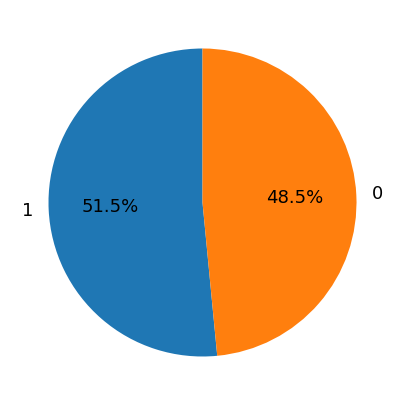

In [8]:
kwargs = dict(
    startangle = 90,
    fontsize   = 13,
    figsize    = (60,5),
    autopct    = '%1.1f%%',
    label      = ''
)

df['Label'].value_counts().plot.pie(**kwargs)

While not perfectly distributed, the class labels are arguebly well balanced.

#### Data Preparation

Text Preprocessing

In [9]:
import re
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer
from nltk.corpus import stopwords

LEMMATIZER = WordNetLemmatizer()
STOP_WORDS = set(stopwords.words('english'))
#define custom stop words to ensure negation words are kept
WORDS_TO_KEEP = {'not', 'but', 'no', 'never', 'none', 'however', 'although', 'yet'}
CUSTOM_STOP_WORDS = STOP_WORDS.difference(WORDS_TO_KEEP)

#text preprocessing including case normalization, special character removal, lematization, etc.
def preprocess(text):
    # Lowercase and remove URLs/special characters
    text = text.lower()
    text = re.sub(r'http\S+', '', text)
    text = re.sub(r'[^a-zA-Z\s.?!.]', '', text)
    
    text = re.sub(r'(?<!\w)[.?!](?!\s|$)', '', text) #remove punctuation that is not at the end of a word
    
    # Remove repetitive characters e.g: looool -> lol. hahaha-> haha
    #text = re.sub(r'(.)\1{2,}', r'\1', text)
    text = re.sub(r'([a-z][a-z])\1+', r'\1\1', text)
    
    # Tokenize and lemmatize
    tokens = word_tokenize(text)
    tokens = [LEMMATIZER.lemmatize(word) for word in tokens]
    
    #Merge back tokens
    result = ""
    for i, token in enumerate(tokens):
        if i > 0 and re.match(r'[.?!,;:]', token):
            result += token  # No space before punctuation
        else:
            result += (" " if result else "") + token #space before word, no space at beginning.
    return result.strip()

df_clean = df.copy()
df_clean['Text'] =  df_clean['Text'].apply(preprocess)
df_clean['Text'] = df_clean['Text'].str.strip()
df_clean.head(5)


,Text,Label
0,forensic audit we conclude that the dominion voting system is intentionally and purposefully designed with inherent error to create systemic fraud and influence election result. so now that they h...,1
1,biden and the squad tlaib stage heated confrontation on tarmac in detroit. tlaib your family is hamas. funded by iran a state sponsor of terrorism. hamas is a terrorist organization rocket shot at...,1
3,not even an issue of politics it wrong this man is being charged. what is going to happen with this trend is that police will not risk getting charged and will not use their weapon unless it is ab...,1
4,young man wearing maga hat attacked at school and spit on by two girl animal. he deserves justice! we got ta start normalizing defending ourselves against woman. screw all that theyre weaker b the...,1
6,trump say working on a very big trade deal with india but will take time. india is rightful where we should pay a significant amount of our attention when it come to that side of the world.,1


#### Transformers & Fine tune

In [10]:
# 1. 数据预处理
X_texts = df_clean['Text'].tolist()
y_labels = df_clean['Label'].values

In [11]:
from sentence_transformers import SentenceTransformer

# 2. 加载预训练的句向量模型
model_sbert = SentenceTransformer("GTR-T5-large")  # 你也可以换成 all-MiniLM-L6-v2
X_vectors = model_sbert.encode(X_texts, convert_to_numpy=True)

In [12]:
# 3. 划分训练集和测试集
X_train, X_temp, y_train, y_temp = train_test_split(
	X_vectors, y_labels, test_size=0.2, stratify=y_labels, random_state=88)

X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, stratify=y_temp, random_state=88)

print(f"Size of X_train: {X_train.shape[0]}")
print(f"Size of X_val: {X_val.shape[0]}")
print(f"Size of X_test: {X_test.shape[0]}")

Size of X_train: 8783
Size of X_val: 1098
Size of X_test: 1098


In [13]:
# 4. 创建 PyTorch Dataset
from torch.utils.data import Dataset, DataLoader
import torch

class TextDataset(Dataset):
    def __init__(self, X, y):
        self.X = torch.tensor(X, dtype=torch.float32)
        self.y = torch.tensor(y, dtype=torch.long)

    def __len__(self):
        return len(self.X)

    def __getitem__(self, idx):
        return self.X[idx], self.y[idx]

train_dataset = TextDataset(X_train, y_train)
test_dataset = TextDataset(X_test, y_test)

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True, num_workers=0)
test_loader = DataLoader(test_dataset, batch_size=32, num_workers=0)

In [14]:
# 5. 定义分类模型
import torch.nn as nn
class MLPClassifier(nn.Module):
    def __init__(self, input_dim=768):
        super().__init__()
        self.net = nn.Sequential(
            nn.Linear(input_dim, 512),
            nn.ReLU(),
            nn.Dropout(0.3),
            nn.Linear(512, 256),
            nn.ReLU(),
            nn.Dropout(0.3),
            nn.Linear(256, 2)
        )

    def forward(self, x):
        return self.net(x)


# 6. 训练模型
clf = MLPClassifier(input_dim=X_train.shape[1])
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
clf.to(device)

optimizer = torch.optim.Adam(clf.parameters(), lr=1e-4, weight_decay=1e-5)
loss_fn = nn.CrossEntropyLoss()

best_loss = float('inf')
patience = 5
counter = 0

for epoch in range(50):
    clf.train()
    total_loss = 0
    for xb, yb in train_loader:
        xb, yb = xb.to(device), yb.to(device)
        pred = clf(xb)
        loss = loss_fn(pred, yb)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        total_loss += loss.item()

    avg_loss = total_loss / len(train_loader)
    print(f"Epoch {epoch+1} loss: {avg_loss:.4f}")

    # Early stopping 检查
    if avg_loss < best_loss - 1e-4:
        best_loss = avg_loss
        counter = 0
    else:
        counter += 1
        if counter >= patience:
            print(f"Early stopping triggered at epoch {epoch+1}!")
            break


Epoch 1 loss: 0.6709
Epoch 2 loss: 0.5929
Epoch 3 loss: 0.5614
Epoch 4 loss: 0.5428
Epoch 5 loss: 0.5294
Epoch 6 loss: 0.5197
Epoch 7 loss: 0.5087
Epoch 8 loss: 0.4950
Epoch 9 loss: 0.4841
Epoch 10 loss: 0.4727
Epoch 11 loss: 0.4618
Epoch 12 loss: 0.4500
Epoch 13 loss: 0.4380
Epoch 14 loss: 0.4224
Epoch 15 loss: 0.4090
Epoch 16 loss: 0.4001
Epoch 17 loss: 0.3855
Epoch 18 loss: 0.3716
Epoch 19 loss: 0.3598
Epoch 20 loss: 0.3429
Epoch 21 loss: 0.3296
Epoch 22 loss: 0.3143
Epoch 23 loss: 0.3018
Epoch 24 loss: 0.2864
Epoch 25 loss: 0.2704
Epoch 26 loss: 0.2562
Epoch 27 loss: 0.2411
Epoch 28 loss: 0.2256
Epoch 29 loss: 0.2129
Epoch 30 loss: 0.1947
Epoch 31 loss: 0.1829
Epoch 32 loss: 0.1718
Epoch 33 loss: 0.1564
Epoch 34 loss: 0.1452
Epoch 35 loss: 0.1307
Epoch 36 loss: 0.1221
Epoch 37 loss: 0.1097
Epoch 38 loss: 0.0966
Epoch 39 loss: 0.0952
Epoch 40 loss: 0.0841
Epoch 41 loss: 0.0803
Epoch 42 loss: 0.0728
Epoch 43 loss: 0.0662
Epoch 44 loss: 0.0603
Epoch 45 loss: 0.0673
Epoch 46 loss: 0.05

In [15]:
from sklearn.metrics import precision_score, recall_score, f1_score
import numpy as np

clf.eval()
correct = 0
total = 0
all_preds = []
all_labels = []

with torch.no_grad():
    for xb, yb in test_loader:
        xb, yb = xb.to(device), yb.to(device)
        pred = clf(xb)
        pred_labels = torch.argmax(pred, dim=1)

        all_preds.extend(pred_labels.cpu().numpy())
        all_labels.extend(yb.cpu().numpy())

        correct += (pred_labels == yb).sum().item()
        total += yb.size(0)

accuracy = correct / total
precision = precision_score(all_labels, all_preds) * 100
recall = recall_score(all_labels, all_preds) * 100
f1 = f1_score(all_labels, all_preds) * 100

# 类别比例
all_preds = np.array(all_preds)
democrat_pct = (all_preds == 0).mean() * 100
republican_pct = (all_preds == 1).mean() * 100

print(f"\nTest Accuracy: {accuracy:.4f}")
print(f"Precision (%): {precision:.2f}")
print(f"Recall (%): {recall:.2f}")
print(f"F1 Score (%): {f1:.2f}")
print(f"Democrat %: {democrat_pct:.2f}")
print(f"Republican %: {republican_pct:.2f}")


Test Accuracy: 0.8087
Precision (%): 82.48
Recall (%): 79.86
F1 Score (%): 81.15
Democrat %: 50.09
Republican %: 49.91


In [16]:
# 8. 用模型对新文本进行分类
def predict(text):
    clf.eval()
    vec = model_sbert.encode([text], convert_to_tensor=True).to(device)
    with torch.no_grad():
        output = clf(vec)
        prediction = torch.argmax(output, dim=1).item()
    return prediction

# 示例：
print("\nExample prediction:")
print(predict("xxx believe in empowering small businesses by cutting red tape and lowering taxes. This fuels job creation and economic independence."))


Example prediction:
1


In [17]:
print(f"Validation set size: {len(X_val)}")
print(f"Test set size: {len(X_test)}")


Validation set size: 1098
Test set size: 1098


In [23]:
# 妈的还要重新split，我之前split的是embeddings向量
texts = df_clean["Text"].tolist()
labels = df_clean["Label"].tolist()

# 原始文本的 train/val/test 划分（保留文本）
X_train_text, X_temp_text, y_train, y_temp = train_test_split(
    texts, labels, test_size=0.2, random_state=88, stratify=labels
)
X_val_text, X_test_text, y_val, y_test = train_test_split(
    X_temp_text, y_temp, test_size=0.5, random_state=88, stratify=y_temp
)


In [24]:
from tqdm import tqdm

val_preds = [predict(text) for text in tqdm(X_val_text)]
pd.DataFrame(val_preds, columns=["label"]).to_csv("val_predictions.csv", index=False)

100%|██████████| 1098/1098 [03:21<00:00,  5.46it/s]


In [25]:

# test 集预测
test_preds = [predict(text) for text in tqdm(X_test_text)]
pd.DataFrame(test_preds, columns=["label"]).to_csv("test_predictions.csv", index=False)


100%|██████████| 1098/1098 [01:24<00:00, 13.02it/s]


In [26]:
# 把text也保留下

def predict_and_export(text_list, filename):
    clf.eval()
    results = []

    for text in text_list:
        vec = model_sbert.encode([text], convert_to_tensor=True).to(device)
        with torch.no_grad():
            output = clf(vec)
            prediction = torch.argmax(output, dim=1).item()
        results.append({
            "text": text,
            "predicted_label": prediction
        })

    df_out = pd.DataFrame(results)
    df_out.to_csv(filename, index=False)
    print(f"Saved to {filename} ")

In [27]:
predict_and_export(X_val_text, "val_predictions_w_t.csv")

Saved to val_predictions_w_t.csv 


In [28]:
predict_and_export(X_test_text, "test_predictions_w_t.csv")

Saved to test_predictions_w_t.csv 
